# Рынок заведений общественного питания Москвы

Для инвесторов требуется анализ небольшого кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. 


## Подготовка данных

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
import warnings
pd.set_option("max_colwidth", 150)

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv', sep=',')

In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропусков нет. Названия столбцов в порядке. Изменять тип данных нет необходимости.

In [4]:
rest_data.duplicated().sum()

0

In [5]:
rest_data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [6]:
rest_data['address']=rest_data['address'].str.lower()

In [7]:
rest_data['object_name']=rest_data['object_name'].str.lower()

In [8]:
rest_data['id'].duplicated().sum()

0

In [9]:
rest_data['number'].unique()

array([  48,   35,   95,   40,   50,  240,   10,   90,  150,  120,    5,
         24,  140,   32,  270,  320,    7,    2,  160,   20,   30,  110,
          6,  192,   65,   45,    4,  125,  100,   49,   63,   70,   22,
         56,   38,  220,   78,    3,   80,   46,   15,   96,   60,   47,
        180,  250,  200,   25,   12,   14,   16,  420,   98,   75,   34,
        216,   43,   54,  580,  159,    0,   28,   64,   67,   42,  124,
         82,   36,  114,    8,   71,   18,  158,   55,  196,   44,   76,
        144,   41,   26,   68,  143,  198,   79,    1,   86,  148,  190,
        202,  131,   52,   92,  300,   85,  102,   88,   84,  246,   81,
         94,   23,   37,   39,   99,   61,   11,  130,   74,  128,  106,
         58,  260,   27,   19,   29,   13,    9,  168,  350,   93,   33,
        105,  239,  104,   17,   62,  230,  132,   87,   89,  170,   83,
         21,  108,  210,   51,   53,  115,   66,  280,  126,   97,  356,
        156,  428,  380,  138,   72,  118,  139,  2

In [10]:
rest_data.sample()

,id,object_name,chain,object_type,address,number
9317,167227,tokyo-japan,нет,ресторан,"город москва, проспект мира, дом 12, строение 1",70


Явных дубликатов нет. Типы объектов в порядке. В колонке с числом посадочных мест ничего подозрительно не выявлено. Данные колонок приведены к нижнему регистру. Названия объектов нет необходимости приводить к единому стилю и находить разные версии одного и того же. На анализ не повлияет.

## Анализ данных 

### График соотношения видов объектов общественного питания по количеству

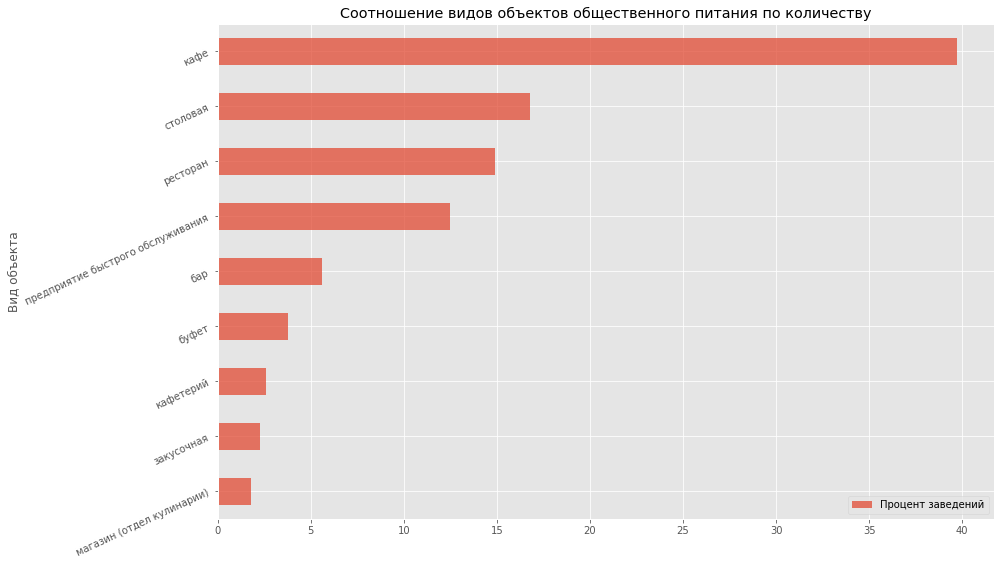

In [11]:
# создаем массив, группируя по типу объекта и считая количество объектов 
types = rest_data.groupby('object_type', as_index=False).agg({'id':'count'}).sort_values(by='id', ascending=True)
# добавляем проценты для наглядности
types['per'] = (types['id']/types['id'].sum()*100).round(1)
plt.style.use('ggplot')
types.plot.barh(rot=25, x='object_type', y='per', figsize=(14,8), grid=True, label='Процент заведений', alpha=0.75)
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.ylabel('Вид объекта')
plt.tight_layout()
plt.show()


Подавляющее большинство(около 40%) объектов относятся к типу "кафе". На втором месте столовые, далее идут рестораны и предприятия быстрого обслуживания. Меньше всего заведений типа "магазин(отдел кулинарии").


### График соотношения сетевых и несетевых заведений по количеству
    

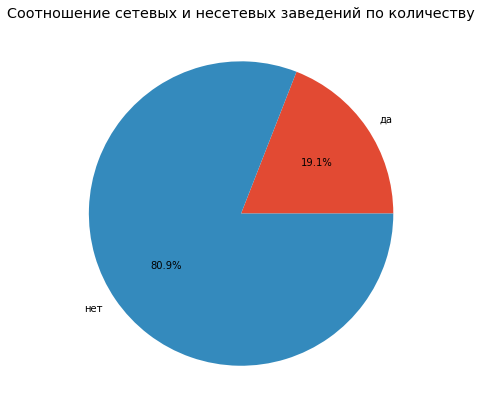

In [12]:
x=rest_data.groupby("chain")['id'].sum()
chains = x.index
with plt.style.context('ggplot'):
    plt.figure(figsize=(15,7))
    plt.pie(x=x, labels=chains, autopct='%1.1f%%')
    plt.title('Соотношение сетевых и несетевых заведений по количеству')
    plt.show()





График показал, что 80.9% всех объектов являются несетевыми. 

### Для какого вида объекта общественного питания характерно сетевое распространение?
    

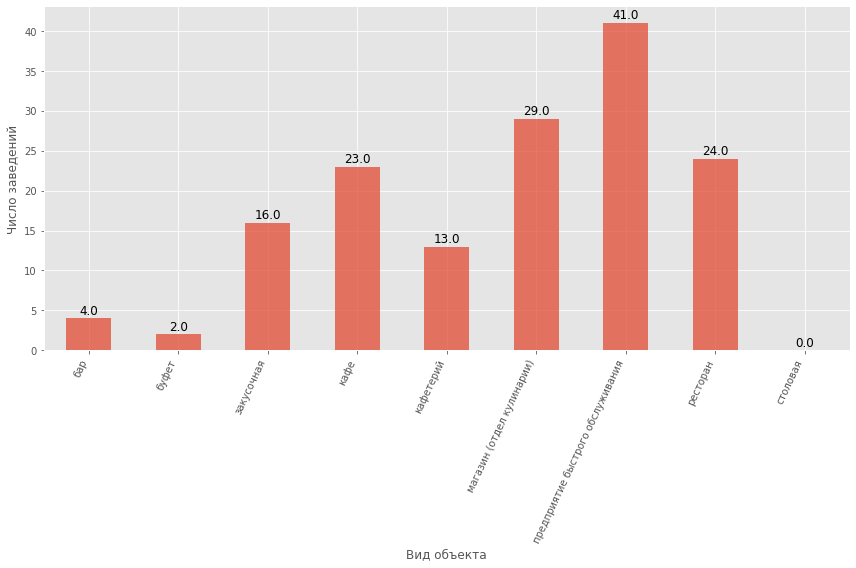

In [13]:
# создаем массив, где отбираем только сетевые заведения 
chain_yes = rest_data.pivot_table(index= 'object_type', columns = 'chain', values = 'id', aggfunc= 'count')
chain_yes['ratio'] = round(
    chain_yes ['да'] / (chain_yes ['да'] + chain_yes ['нет']) * 100
)

plots = chain_yes.plot.bar(y='ratio', figsize=(12,8), grid=True, legend=False, alpha=0.75)
plt.xticks(rotation=65, horizontalalignment="right")
for bar in plots.patches:
    plots.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel('Вид объекта'), plt.ylabel('Число заведений')
plt.tight_layout()

На первом месте стоит тип "предприятие быстрого обслуживания", 41% заведений данного типа сетевые. На втором месте отделы кулинарии(29% - сетевые) и затем идут рестораны(24% из них сетевые). 

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
    

(Text(0.5, 0, 'Число заведений'),
 Text(0, 0.5, 'Среднее число посадочных мест'))

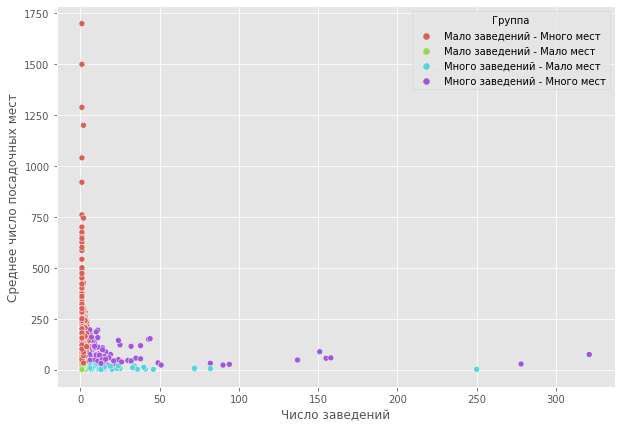

In [14]:
chains = rest_data.query('chain == "да"')
chains = rest_data.groupby('object_name').agg({'id' : 'count', 'number' : 'mean'})
chains['rest_num'] = 'Мало заведений'
chains.loc[chains['id'] > 5, 'rest_num'] = 'Много заведений'

chains['seat_num'] = 'Мало мест'
chains.loc[chains['number'] > 20, 'seat_num'] = 'Много мест'

chains['Группа'] = chains['rest_num'].astype(str) + ' - ' + chains['seat_num'].astype(str)
plt.figure(figsize=(10, 7))
sns.scatterplot(palette='hls', data = chains, x = 'id', y = 'number', hue = 'Группа')
plt.xlabel('Число заведений'), plt.ylabel('Среднее число посадочных мест')



In [15]:
chains.reset_index().groupby('Группа').agg({'object_name': 'nunique', 'id' : 'median', 'number' : 'median'})\
                                      .rename(columns = {'object_name': 'Число сетей', 'id' : 'Медианное число заведений', 'number' : 'Медианное число посадочных мест'})  


,Число сетей,Медианное число заведений,Медианное число посадочных мест
Группа,,,
Мало заведений - Мало мест,2821,1.0,10.000000
Мало заведений - Много мест,6925,1.0,60.000000
Много заведений - Мало мест,72,9.5,6.782738
Много заведений - Много мест,106,10.0,56.896624


Для сетевых заведений характерно мало зведений с большим количеством мест. 

### График видов объектов общественного питания и среднего количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест
    

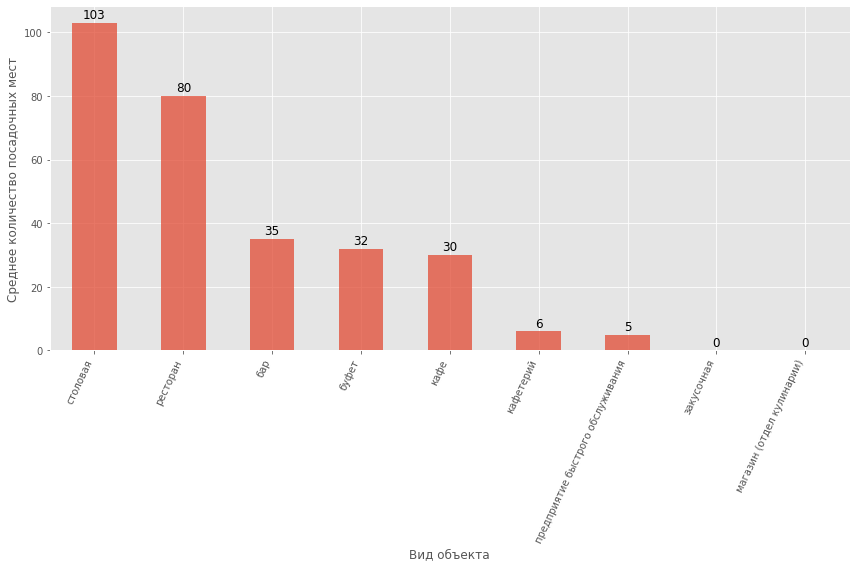

In [16]:
number_yes = rest_data.groupby('object_type', as_index=False).agg({'id':'count', 'number' : 'median'}).sort_values(by='number', ascending=False)

plots = number_yes.plot.bar(x='object_type', y='number', figsize=(12,8), grid=True, legend=False, alpha=0.75)
plt.xticks(rotation=65, horizontalalignment="right")
for bar in plots.patches:
    plots.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel('Вид объекта'), plt.ylabel('Среднее количество посадочных мест')
plt.tight_layout()

Самое большое среднее количество посадочных мест в столовых. Также большое количество посадочных мест наблюдается в ресторанах. По нулям в закусочных и отделах кулинарии.

Для дальнейшего анализа выделим в отдельный столбец информацию об улице из столбца address.
   

In [17]:
rest_data['street'] = rest_data['address'].apply(lambda x: x.split(', ')[1])
rest_data['street']  = rest_data['street'].str.strip()
rest_data.head(5)


,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


### График топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?
   

In [18]:
top_10 = rest_data.groupby('street').agg({'id' : 'count'}).sort_values(by='id', ascending=False)
top_10 = top_10.head(10)
top_10

,id
street,
город зеленоград,232
проспект мира,204
профсоюзная улица,182
ленинградский проспект,171
пресненская набережная,167
варшавское шоссе,161
ленинский проспект,147
поселение сосенское,138
проспект вернадского,132


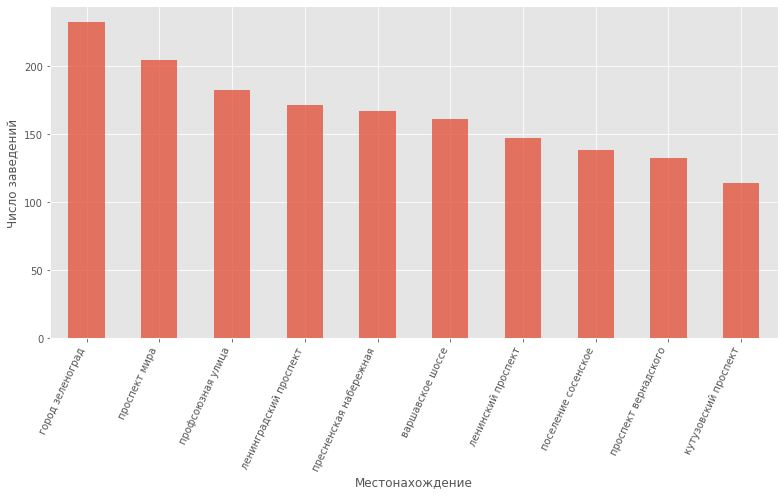

In [19]:
top_10.plot.bar(legend=False, alpha=0.75, figsize=(11,7))
plt.xticks(rotation=65, horizontalalignment="right")
xlabel='street'
plt.xlabel('Местонахождение'), plt.ylabel('Число заведений')
plt.tight_layout()

Выигрывает Зеленоград, однако у Зеленограда статус административного округа. Что несет в себе отдельные причины. На втором месте проспект Мира, далее Профсоюзная улица.

In [20]:
from io import BytesIO
import requests
spreadsheet_id = '1CPDYDGjKCb6jGoQt9KR5WOvTspK-dHS3NUrVeqsyqJs'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df['streetname'] = df['streetname'].str.lower()
df

,streetname,areaid,okrug,area
0,выставочный переулок,17,ЦАО,Пресненский район
1,улица гашека,17,ЦАО,Пресненский район
2,большая никитская улица,17,ЦАО,Пресненский район
3,глубокий переулок,17,ЦАО,Пресненский район
4,большой гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,вознесенский проезд,17,ЦАО,Пресненский район
4394,волков переулок,17,ЦАО,Пресненский район
4395,поварская улица,17,ЦАО,Пресненский район
4396,кудринская площадь,17,ЦАО,Пресненский район


In [21]:
streets_area = top_10.merge(df[['streetname', 'area']], left_on='street', right_on='streetname')

streets_area = streets_area.groupby('area').agg({'streetname' : 'nunique'}).sort_values(by='streetname', ascending=False)
streets_area

,streetname
area,
Район Гагаринский,2
Донской район,2
Ломоносовский район,2
Район Проспект Вернадского,2
Обручевский район,2
Район Теплый Стан,2
Район Тропарево-Никулино,2
Академический район,1
Район Северное Бутово,1


Мы получили список районов, в которых располагаются вышеуказанные улицы. Большинство улиц пролегают сквозь несколько районов. 

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [22]:
one_object = rest_data.groupby('street').agg({'id' : 'count'})
one_object = one_object.query('id == 1')
print('Число улиц с одним объектом общественного питания:', len(one_object))

Число улиц с одним объектом общественного питания: 579


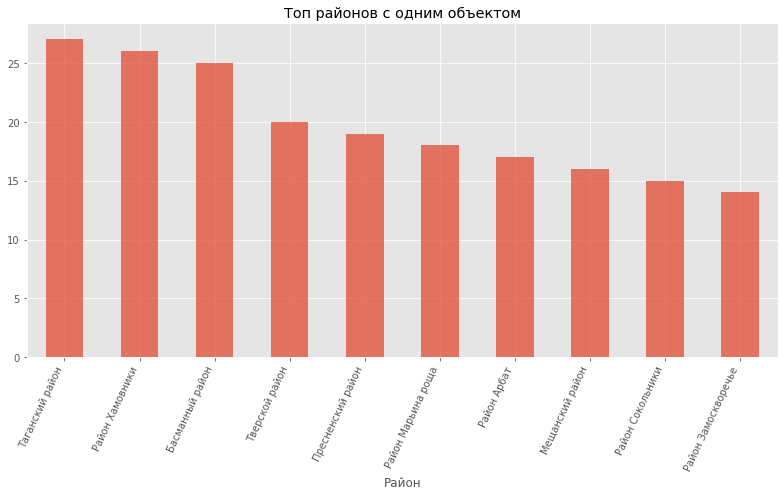

In [23]:
one_object_area = one_object.merge(df[['streetname', 'area']], left_on='street', right_on='streetname')
one_object_area = one_object_area.groupby('area').agg({'streetname' : 'count'}).sort_values(by='streetname', ascending=False).head(10)
one_object_area.plot.bar(legend=False, alpha=0.75, figsize=(11,7))
plt.xticks(rotation=65, horizontalalignment="right")
plt.xlabel('Район')
plt.title('Топ районов с одним объектом')
plt.tight_layout()

Из графика видим, что в тройку лидеров районов со одним объектом входят Таганский район, Хамовники и Басманный район.

### График распределения количества посадочных мест для улиц с большим количеством объектов общественного питания 

Медианное количество посадочных мест на топовых улицах: 38.0
Медианное количество посадочных мест всех заведений: 40.0


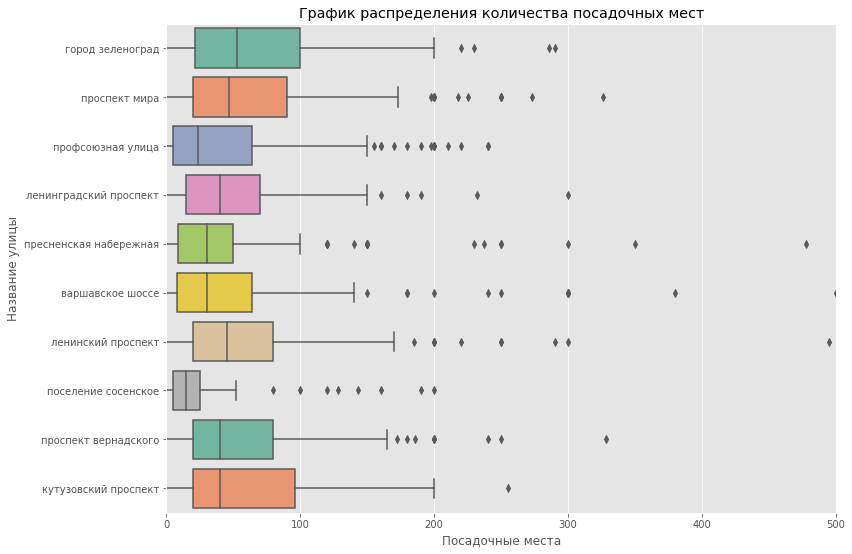

In [24]:
top_num = pd.merge(top_10, rest_data, on="street", how="left")
plt.figure(figsize=(12, 9))
plt.title("График распределения количества посадочных мест")
sns.boxplot(x='number', y='street', data=top_num, palette="Set2") 
plt.xlim([0, 500])
plt.ylabel('Название улицы')
plt.xlabel('Посадочные места')
print('Медианное количество посадочных мест на топовых улицах:', top_num['number'].median())
print('Медианное количество посадочных мест всех заведений:',rest_data['number'].median())



Посадочные места распределены довольно однородно. 
Разницы между медианным количеством мест на топовых улицах и по общему датасету практически нет. На всех улицах пределы "ящика" лежат до 100 посадочных мест, можем наблюдать, что в части улиц медиана смещена к первому квартилю. Верхняя граница в большинстве случаев лежит в диапазоне от 150 до 200 посадочных мест. Медианное количество мест - 40, и оно сохраняется в по улицам. Поселение сосенское отличается малым количеством, но стоит уточнить, брать ли во внимание его далее. 

## Выводы

Из проведенного анализа можно сделать следующие выводы: 

- Самый распространенный тип объекта  - кафе(39.7%), за ним идут столовые(16.8%) и рестораны(14.9%)
- Меньше всего объектов типа "магазин (отдел кулинарии)"
- Сетевое распространение характерно для типа объекта "предприятие быстрого обслуживания", 41% заведений данного типа сетевые. На втором месте отделы кулинарии(29% - сетевые) и затем идут рестораны(24% из них сетевые). 
- Меньше всего сетевых столовых  и буфетов.
- Для сетевых заведений характерно мало зведений с большим количеством мест. 
- Самое большое среднее количество посадочных мест в столовых(103 места) и ресторанах(80 мест). 
- В закусочных и отделах кулинарии посадочных мест нет.
- Топ-10 улиц с наибольшим количеством объектов общественного питания:
    
    город Зеленоград
    проспект Мира
    Профсоюзная улица
    Ленинградский проспект 	
    Пресненская набережная 	
    Варшавское шоссе 	
    Ленинский проспект 	
    поселение Сосенское 	
    проспект Вернадского 	
    Кутузовский проспект 	

- Число улиц с одним объектом общественного питания: 579
- Тройка лидеров районов со одним объектом  - Таганский район, Хамовники и Басманный район.
- Посадочные места распределены довольно однородно. 
- Разницы между медианным количеством мест на топовых улицах и по общему датасету практически нет. На всех улицах пределы "ящика" лежат до 100 посадочных мест, можем наблюдать, что в части улиц медиана смещена к первому квартилю. Верхняя граница в большинстве случаев лежит в диапазоне от 150 до 200 посадочных мест. Медианное количество мест - 40, и оно сохраняется в по улицам. Поселение сосенское отличается малым количеством, но стоит уточнить, брать ли во внимание его далее. .

Делать прогнозы о популярности оригинального кафе только на основе полученных данных сложно. Однако можно сделать ставку на оригинальности и поместить кафе на одну из улиц из топа районов по количеству заведений, так мы обеспечим проходимость и переманим клиентов других заведений, однако, чтобы удержаться надо, как минимум, исследовать ценовую политику и тематику кухни. Так как планируемое кафе небольшое и несетевое, возможно стоит рассмотреть более тихие места, с малым количеством конкурентов вокруг. Стоит также проанализировать районы на  социальные группы, на каких посителей рассчитано, в первую очередь, наше кафе. Выбрать место среди офисных зданий или в популярном месте отдыха молодежи и так далее. 